## Project II: Logistic Regression on Fashion-MNIST Data


In [1]:
#import modules 
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
# bigger fonts
plt.rcParams['font.size'] = 18 #font size in matplotlib

### Import keras bits and pieces from tensorflow

In [2]:
from tensorflow import keras 
from tensorflow.keras.datasets import fashion_mnist #dataset
from tensorflow.keras.models import Sequential #architecture
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten #different layers for CNN
from tensorflow.keras.optimizers import RMSprop, Adam #loss func

### Fashion MNIST images
#### Zalando's article images

![MNIST](https://www.kindpng.com/picc/m/633-6330443_png-tf-keras-datasets-fashion-mnist-transparent-png.png "MNIST")


In [5]:
LABEL_NAMES = ['t_shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']


In [4]:
# the data, split between train and test sets
(x_train, y_train), (x_valtest, y_valtest) = fashion_mnist.load_data()
print(len(y_train)) #y train = labels
print(len(x_train)) #x train = images
len(y_valtest)

4422102/4422102 [==============================] - 0s 0us/step
60000
60000


10000

In [6]:
# demo the effect of noisy data
#x_train = (x_train/5 + np.random.poisson(200, size=x_train.shape)).clip(0, 255)
#x_valtest = (x_valtest/5 + np.random.poisson(200, size=x_valtest.shape)).clip(0, 255)


### Training, test and validation data splitting

#### Training Dataset: 
The sample of data used to fit the model while training
#### Validation Dataset: 
The sample of data used to provide an unbiased evaluation of a model fit
#### Test Dataset:
The sample of data used to provide an unbiased evaluation of a final model fit 

Splitting done with "train_test_split" function of sklearn

In [7]:
from sklearn.model_selection import train_test_split 
x_test, x_val, y_test, y_val = train_test_split(x_valtest, y_valtest, test_size=0.5)
#divided valtest into equal sets of 5k 
print(len(x_test))
print(len(x_val))

5000
5000


We explore the effect of train_test_split

In [8]:
x_train.shape, y_train.shape # 28*28 images # of images 60k

((60000, 28, 28), (60000,))

In [9]:
x_test.shape, y_test.shape #similar dimensions as train

((5000, 28, 28), (5000,))

In [10]:
x_val.shape, y_val.shape

((5000, 28, 28), (5000,))

### Visualising the curated data


class = dress


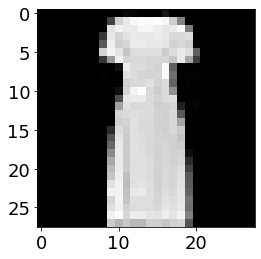

In [11]:
i = 50 
plt.imshow(x_train[i], cmap='gray')
print('class =', LABEL_NAMES[y_train[i]])



class = bag


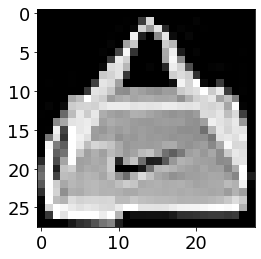

In [12]:
i = 4139
plt.imshow(x_train[i], cmap='gray')
print('class =', LABEL_NAMES[y_train[i]])

### Prepare the data

Y variables are 10 classes corresponding to 10 distinct zalando images

**One-hot** changes this simple number (class) to a matrix which contains 0 for all the entries except for that particular class

This is simply implemented using keras utilities

In [13]:
# converting class vectors to "one-hot" class matrices
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

In [14]:
y_train[4139]
#y_test[i]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

Now the inputs, the images:

Take the 28X28 bins of images (=784) with levels of gray 0 to 255 and

flatten them in an array and re-scale the content (intensity of gray) from 0 to 1

In [15]:
def process_data(x):
    x = x.reshape(-1, 784) #60000*28*28 reshaped to 60000*784
    x = x.astype('float32')
    x /= 255 #normalise
    return x

In [16]:
x_train = process_data(x_train)
x_test = process_data(x_test)
x_val = process_data(x_val)


In [17]:
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_val.shape[0], 'validation samples')

60000 train samples
5000 test samples
5000 validation samples


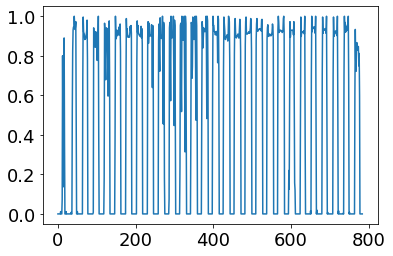

In [18]:
plt.plot(x_train[500]) #pixel values of an image


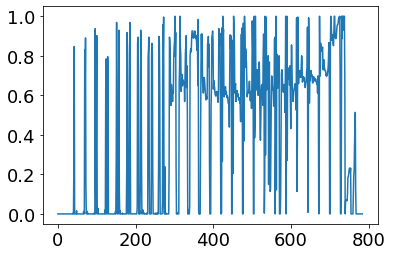

In [19]:
plt.plot(x_train[4139])

### Build the NN model 1

In [20]:
# Sequential means you can build a DNN layer by layer
fcmodel = Sequential() 
# Dense has as arguments: 
# number of neurons, type of activation function, and the input needs to match the output of the previous layer
# input_shape=(N_features,) where N_features = 28*28
fcmodel.add(Dense(32, activation='relu', input_shape=(784,))) 
# we add a second layer
fcmodel.add(Dense(32, activation='relu'))
# could include dropout, regularisation, ...
fcmodel.add(Dense(num_classes, activation='softmax')) 
#the last dense layer has no of neurons equivalent to no. of classes


In [21]:
fcmodel.summary() #shows the architecture
# no of pars = # of neurons in the prev layer * # of neurons in current layer + # of bias
print(784*32+32, 32*32+32 , 32*10+10)

#

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                25120     
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
Total params: 26,506
Trainable params: 26,506
Non-trainable params: 0
_________________________________________________________________
25120 1056 330


Next, we choose the loss function according to which we will train the DNN 

For classification problems, this is usually the cross-entropy, and since the output data was cast in categorical
form, we choose the categorical_crossentropy defined in Keras’ losses module 

To optimize the weights of the net, we use SGD (Stochastic Gradient Descent) or other typical choices are RMSprop or Adam



In [22]:
fcmodel.compile(loss='categorical_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

### Training the NN

The **batch size** defines the number of samples that will be propagated through the network.

We have 60000 training samples and we set up a batch_size equal to 32. The algorithm takes the first 32 samples from the training dataset and trains the network. Next, it takes the second batch and trains the network again, and keep with this procedure until we have propagated all samples through of the network. 

**Training epochs** defines the number times that the learning algorithm will work through the entire training dataset.


In [23]:
batch_size = 32 #will send 32 images at once to train, each image has 784 pixels
epochs = 20

In [24]:
# training the NN
history = fcmodel.fit(x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(x_val, y_val))
#history will store train(val) loss and accuracy

Epoch 1/20
1875/1875 [==============================] - 11s 3ms/step - loss: 0.5418 - accuracy: 0.8097 - val_loss: 0.4580 - val_accuracy: 0.8374
Epoch 2/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3930 - accuracy: 0.8601 - val_loss: 0.4292 - val_accuracy: 0.8470
Epoch 3/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3591 - accuracy: 0.8706 - val_loss: 0.3896 - val_accuracy: 0.8654
Epoch 4/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3371 - accuracy: 0.8774 - val_loss: 0.3924 - val_accuracy: 0.8572
Epoch 5/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3228 - accuracy: 0.8824 - val_loss: 0.3621 - val_accuracy: 0.8698
Epoch 6/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3099 - accuracy: 0.8864 - val_loss: 0.3708 - val_accuracy: 0.8636
Epoch 7/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3017 - accuracy: 0.8891 - val_loss: 0.3499 - val_accuracy

In [25]:
#assuming the model more or less fits the data, we check the error on the prediction
score = fcmodel.evaluate(x_test, y_test, verbose=0) 
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.38013318181037903
Test accuracy: 0.875


In [26]:
def histplot(history):
    hist = pd.DataFrame(history.history)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    hist.plot(y=['loss','val_loss'], ax=ax1)
    min_loss = hist['val_loss'].min()
    ax1.hlines(min_loss, 0, len(hist), linestyle='dotted',
               label='min(val_loss) = {:.3f}'.format(min_loss))
    ax1.legend(loc='upper right')
    hist.plot(y=['accuracy','val_accuracy'], ax=ax2)
    max_acc = hist['val_accuracy'].max()
    ax2.hlines(max_acc, 0, len(hist), linestyle='dotted',
               label='max(val_accuracy) = {:.3f}'.format(max_acc))
    ax2.legend(loc='lower right', fontsize='large')

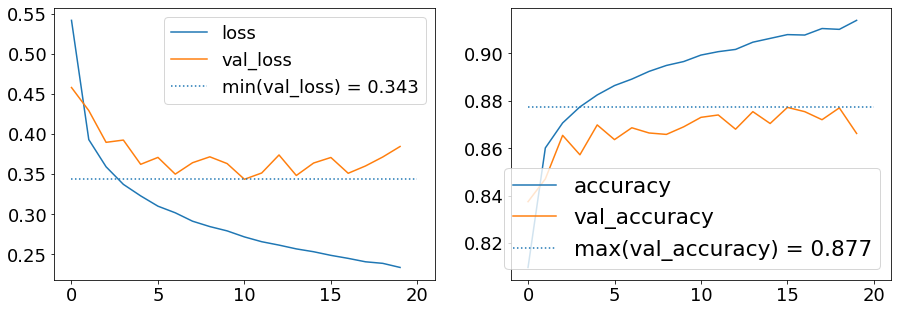

In [27]:
histplot(history)

### There is slight overfitting. We will consider a different NN model with regulariser to avoid overfitting.

## Build NN model2
## Adding Dropout & Regulariser

In [28]:
# Sequential means you can build a DNN layer by layer
fcmodel2 = Sequential() 
# Dense has as arguments: 
# number of neurons, type of activation function, and the input needs to match the output of the previous layer
# input_shape=(N_features,) where N_features = 28*28
fcmodel2.add(Dense(64, activation='relu', input_shape=(784,))) 
# we add a second layer
fcmodel2.add(Dense(64, activation='relu'))
# we add a third layer
fcmodel2.add(Dense(64, activation='relu'))
# could include dropout, regularisation, ...
fcmodel2.add(Dropout(0.3))
fcmodel2.add(Dense(num_classes, activation='softmax')) 
#the last dense layer has no of neurons equivalent to no. of classes
# activation 
fcmodel2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                50240     
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 10)                650       
                                                                 
Total params: 59,210
Trainable params: 59,210
Non-trainable params: 0
_________________________________________________________________


In [29]:
fcmodel2.compile(loss='categorical_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])
history = fcmodel2.fit(x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(x_val, y_val))

Epoch 1/20
1875/1875 [==============================] - 9s 4ms/step - loss: 0.5851 - accuracy: 0.7936 - val_loss: 0.4534 - val_accuracy: 0.8322
Epoch 2/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4144 - accuracy: 0.8508 - val_loss: 0.4060 - val_accuracy: 0.8538
Epoch 3/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3758 - accuracy: 0.8658 - val_loss: 0.4107 - val_accuracy: 0.8474
Epoch 4/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3528 - accuracy: 0.8720 - val_loss: 0.3684 - val_accuracy: 0.8662
Epoch 5/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3356 - accuracy: 0.8786 - val_loss: 0.3872 - val_accuracy: 0.8536
Epoch 6/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3217 - accuracy: 0.8826 - val_loss: 0.3505 - val_accuracy: 0.8704
Epoch 7/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3095 - accuracy: 0.8876 - val_loss: 0.3559 - val_accuracy:

In [30]:
score = fcmodel2.evaluate(x_test, y_test, verbose=0) 
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 0.36454054713249207
Test accuracy: 0.8794000148773193


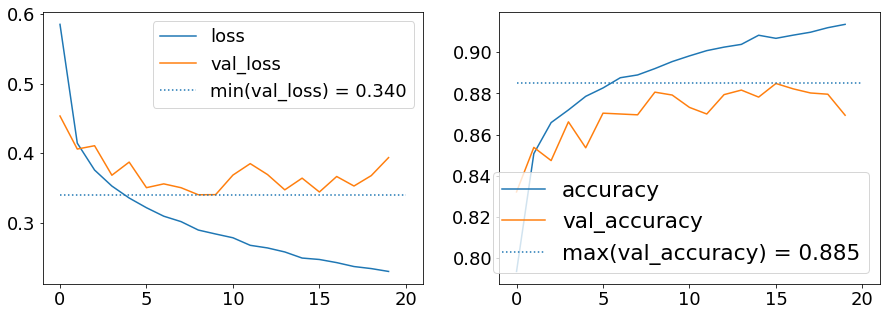

In [32]:
histplot(history)

### With more layers, the network gets more dense and validation and train data accuracies are closer. Overfitting is reduced. The accuracy has not improved much though despite several strategies adopted. Lets try to train the data with CNN.

##  Convolutional Neural Network (CNN)

### Reshaping the data  

In [33]:
x_train = x_train.reshape(-1, 28, 28, 1) #converting them to image, the last index stands for color
x_test = x_test.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)

In [34]:
x_train.shape

(60000, 28, 28, 1)

###  Construct the network

In [35]:
# a fairly small network for speed
cnnmodel = Sequential()
cnnmodel.add(Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 1)))
cnnmodel.add(MaxPooling2D((3, 3)))
cnnmodel.add(Conv2D(32, (3, 3), activation='relu'))
cnnmodel.add(MaxPooling2D((2, 2)))
cnnmodel.add(Flatten())
cnnmodel.add(Dropout(0.2))
cnnmodel.add(Dense(num_classes, activation='softmax'))


In [36]:
cnnmodel.compile(loss='categorical_crossentropy',
                optimizer=Adam(lr=0.001),
                metrics=['accuracy'])

In [37]:
cnnmodel.summary()
# of pars in the first conv layer = (3 * 3) * 8 + 8
# of pars in the 2nd conv layer = (3 * 3) * 8 * 16 + 16

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 16)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 32)          4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 288)               0         
                                                                 
 dropout_1 (Dropout)         (None, 288)              

### Train the CNN

In [38]:
history = cnnmodel.fit(x_train, y_train,
                       batch_size=32, 
                       epochs=20,
                       verbose=1,
                       validation_data=(x_val, y_val))

Epoch 1/20
1875/1875 [==============================] - 14s 5ms/step - loss: 0.6547 - accuracy: 0.7636 - val_loss: 0.4747 - val_accuracy: 0.8240
Epoch 2/20
1875/1875 [==============================] - 8s 5ms/step - loss: 0.4605 - accuracy: 0.8328 - val_loss: 0.4181 - val_accuracy: 0.8470
Epoch 3/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4073 - accuracy: 0.8511 - val_loss: 0.3845 - val_accuracy: 0.8570
Epoch 4/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3790 - accuracy: 0.8631 - val_loss: 0.3794 - val_accuracy: 0.8580
Epoch 5/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3623 - accuracy: 0.8686 - val_loss: 0.3497 - val_accuracy: 0.8732
Epoch 6/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3501 - accuracy: 0.8721 - val_loss: 0.3540 - val_accuracy: 0.8658
Epoch 7/20
1875/1875 [==============================] - 8s 5ms/step - loss: 0.3388 - accuracy: 0.8766 - val_loss: 0.3407 - val_accuracy

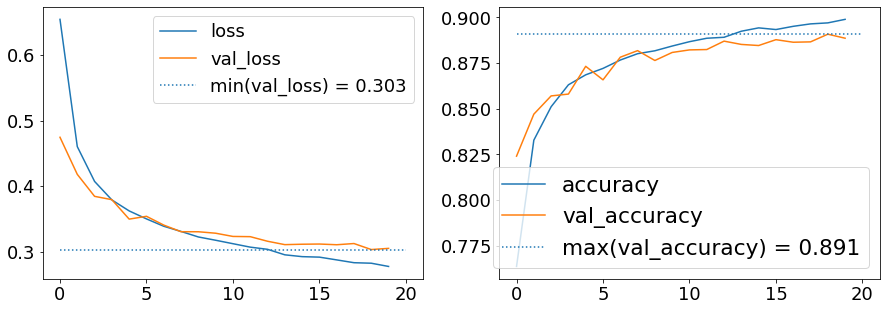

In [39]:
histplot(history)

With CNN, the accuracy is more with higher no of layers. 

In [43]:
from keras.preprocessing import image #discontinued
import keras.utils
img = x_test[130]
test_image = keras.utils.img_to_array(img)
test_image = np.expand_dims(test_image, axis=0)
prediction = cnnmodel.predict(test_image)
print(prediction)
print(np.argmax(prediction, axis=1)) #one hot to integer




1/1 [==============================] - 0s 28ms/step
[[9.68365192e-01 1.13325086e-07 4.23627149e-04 9.93264894e-06
  6.15449562e-06 1.17000598e-09 3.11940517e-02 3.33449278e-13
  8.81996584e-07 2.79206033e-11]]
[0]


In [44]:
# save weights for reinitialising below
cnnmodel.save_weights('/tmp/cnnmodel_init_weights.tf')

## Data augmentation

Data augmentation is a technique to artificially create new training data from existing training data by rotating, obscuring or other transformations in the original data. 

In [45]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=20.0,
    zoom_range=0.05
    )

#datagen.fit(x_train)  # only required if normalizing

In [46]:
gen = datagen.flow(x_train, y_train, batch_size=1)

label = pullover


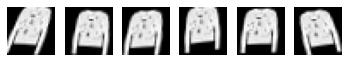

In [47]:
# run this several times to see more augmented examples
i = 9
fig, axarr = plt.subplots(1, 6)
for ax in axarr:
    img = gen[i][0][0, : , :, 0]
    ax.imshow(img, cmap='gray');
    ax.axis('off')
print('label =', LABEL_NAMES[gen[i][1][0].argmax()])

In [48]:
# Reinitialise model
cnnmodel.load_weights('/tmp/cnnmodel_init_weights.tf') #loads the weights from the optimised model

In [49]:
cnnmodel.compile(loss='categorical_crossentropy',
                 optimizer=RMSprop(),
                 metrics=['accuracy'])

In [50]:
# fits the model on batches with real-time data augmentation:
# the accuracy continues to (slowly) rise, due to the augmentation
# it may be convenient to deepen the NN, adding more layers, so it can handle it
history = cnnmodel.fit_generator(datagen.flow(x_train, y_train, batch_size=30), 
                                 epochs=5,
                                 verbose=1,
                                 validation_data=(x_val, y_val))

Epoch 1/5


<ipython-input-50-03b521cbea8c>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = cnnmodel.fit_generator(datagen.flow(x_train, y_train, batch_size=30),


2000/2000 [==============================] - 33s 16ms/step - loss: 0.4974 - accuracy: 0.8158 - val_loss: 0.3567 - val_accuracy: 0.8734
Epoch 2/5
2000/2000 [==============================] - 31s 16ms/step - loss: 0.4605 - accuracy: 0.8299 - val_loss: 0.3702 - val_accuracy: 0.8684
Epoch 3/5
2000/2000 [==============================] - 31s 15ms/step - loss: 0.4484 - accuracy: 0.8344 - val_loss: 0.3780 - val_accuracy: 0.8628
Epoch 4/5
2000/2000 [==============================] - 32s 16ms/step - loss: 0.4441 - accuracy: 0.8364 - val_loss: 0.3785 - val_accuracy: 0.8684
Epoch 5/5
2000/2000 [==============================] - 31s 16ms/step - loss: 0.4382 - accuracy: 0.8400 - val_loss: 0.3981 - val_accuracy: 0.8642


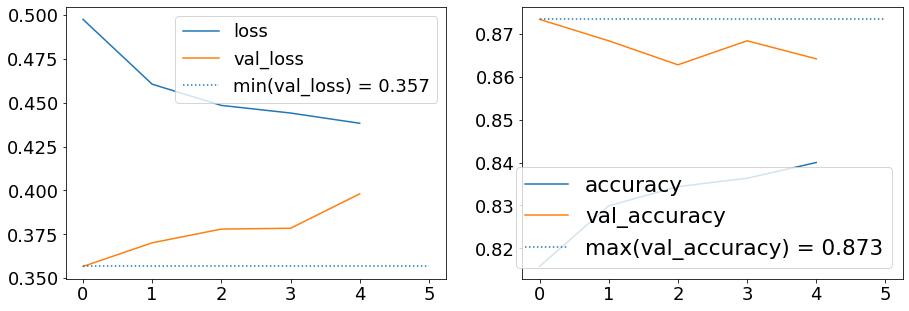

In [51]:
histplot(history)